## 课时71 TF2.0版本WGAN实现

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import glob
AUTOTUNE = tf.data.experimental.AUTOTUNE
%matplotlib inline
tf.__version__

'2.4.0'

### 1. 读取数据以及数据预处理

In [31]:
images_path = "../training_data/apple2orange 2"
os.listdir(images_path)

['.DS_Store', 'testA', 'trainB', 'testB', 'trainA']

In [32]:
# 获取各自文件夹下对应的所有图片
train_images_A_path = glob.glob(images_path + '/trainA/*.jpg')
train_images_B_path = glob.glob(images_path + '/trainB/*.jpg')
test_images_A_path = glob.glob(images_path + '/testA/*.jpg')
test_images_B_path = glob.glob(images_path + '/testB/*.jpg')

In [33]:
def read_jpg_images(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32)/127.5 - 1
    return input_image

def load_jpg_image(image_path):
    img = read_jpg_images(image_path)
    img = tf.image.resize(img, (256, 256)) # 这一步可做可不做
    img = normalize(img)
    return img

In [34]:
# 创建dataset
train_A_dataset = tf.data.Dataset.from_tensor_slices(train_images_A_path)
train_B_dataset = tf.data.Dataset.from_tensor_slices(train_images_B_path)
test_A_dataset = tf.data.Dataset.from_tensor_slices(test_images_A_path)
test_B_dataset = tf.data.Dataset.from_tensor_slices(test_images_B_path)

In [35]:
BUFFER_SIZE = 200
BATCH_SIZE = 1
train_A_dataset = train_A_dataset.map(load_jpg_image, 
        num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_B_dataset = train_B_dataset.map(load_jpg_image, 
        num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_A_dataset = test_A_dataset.map(load_jpg_image, 
        num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_B_dataset = test_B_dataset.map(load_jpg_image, 
        num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

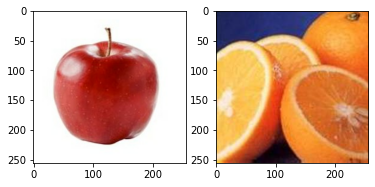

In [42]:
train_dataset = tf.data.Dataset.zip((train_A_dataset, train_B_dataset))
test_dataset = tf.data.Dataset.zip((test_A_dataset, test_B_dataset))

# 显示一下图片
for apple_image, orange_image in train_dataset.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(apple_image[0]))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(orange_image[0]))

### 2. 实例标准化(Instance Normalization)
>Instance Normalization作用于单张图片，而Batch Normalization作用于一个batch的图片，实例标准化非常适合用于style transfer任务中

In [43]:
!pip install -i https://pypi.douban.com/simple tensorflow_addons

Looking in indexes: https://pypi.douban.com/simple
     |████████████████████████████████| 515 kB 1.0 MB/s 


In [44]:
import tensorflow_addons as tfa

### 3. 创建生成器和判别器

In [45]:
# 定义上采样和下采样，方便堆叠U-Net结构
def downsample(filters, kernel_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, 
                               strides=2, padding='same'),
        tfa.layers.InstanceNormalization(),
        tf.keras.layers.LeakyReLU()])
    return model

In [46]:
def upsample(filters, kernel_size, rate=0):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, 
                                        strides=2, padding='same'),
        # 实例标准化
        tfa.layers.InstanceNormalization(),
        # 默认的rate=0代表不使用dropout
        tf.keras.layers.Dropout(rate=rate),
        tf.keras.layers.LeakyReLU()])
    return model

In [ ]:
# 定义生成器
def Generator():
    # 使用函数式API进行模型定义
    inputs = tf.keras.layers.Input(shape=(256, 256, 3))
    down_stack = [downsample(filters=64,  kernel_size=4),  # [128, 128, 64]
                  downsample(filters=128, kernel_size=4),  # [64, 64, 128]
                  downsample(filters=256, kernel_size=4),  # [32, 32, 256]
                  downsample(filters=512, kernel_size=4),  # [16, 16, 512]
                  downsample(filters=512, kernel_size=4),  # [8, 8, 512]
                  downsample(filters=512, kernel_size=4),  # [4, 4, 512]
                  downsample(filters=512, kernel_size=4),  # [2, 2, 512]
                  downsample(filters=512, kernel_size=4)]  # [1, 1, 512]
    
    up_stack = [upsample(filters=512, kernel_size=4, rate=0.5), # [2, 2, 512]
                upsample(filters=512, kernel_size=4, rate=0.5), # [4, 4, 512]
                upsample(filters=512, kernel_size=4, rate=0.5), # [8, 8, 512]
                upsample(filters=512, kernel_size=4),           # [16, 16, 512]
                upsample(filters=256, kernel_size=4),           # [32, 32, 256]
                upsample(filters=128, kernel_size=4),           # [64, 64, 128]
                upsample(filters=64,  kernel_size=4)]           # [128, 128, 64]
    # 将concat之后的结果进行输出 [256, 256, 3]
    last = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=4, strides=2, 
                                           padding='same', activation='tanh')
    
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)